# Predicting the functionality of Vibration Dampers for Cars

The following code was created in cooperation with the FSD GmbH in 2022. 
During the general inspection a car has to pass a crossing threshold while a motion sensor inside the car captures both the deflection and acceleration data in all 3 space dimensions. Based on the recorded data the inspector will evaluate the functionality of both front and rear vibration dampers.

The goal was to automate this evaluation process by training a neural net on the provided dataset. 

In [1]:
import numpy as np
import pandas as pd
#%pip install tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Important!!!!!!!!!!
The original data is under a non-disclosure agreement and was stored in HDF-5-files and then read to pandas Dataframes. Thus this github-repository is not using the original data and only meant to showcase the process and applied techniques.

To emulate the data we construct random DataFrames of the same format.

In [2]:
def createArtificialRandomTrainingData(size): 
    t = np.linspace(0,2,100)
    list_of_dfs, labels = [], []
    for _ in itertools.repeat(None,size):
        x = np.abs(np.cumsum(np.random.randn(100)))
        y = np.abs(np.cumsum(np.random.randn(100)))
        z = np.abs(np.cumsum(np.random.randn(100)))
        list_of_dfs.append(pd.DataFrame({'Time':t, 'ax': x, 'ay': y, 'az': z}))
        label = pd.DataFrame({'Label': np.random.randint(0,2)}, index = [0])
        labels.append(label)
    return list_of_dfs, labels
x_trainPre, y_trainPre = createArtificialRandomTrainingData(10000)

We start by plotting one example of a functioning vibration damper (label = 1) and one of a broken damper (label = 0).

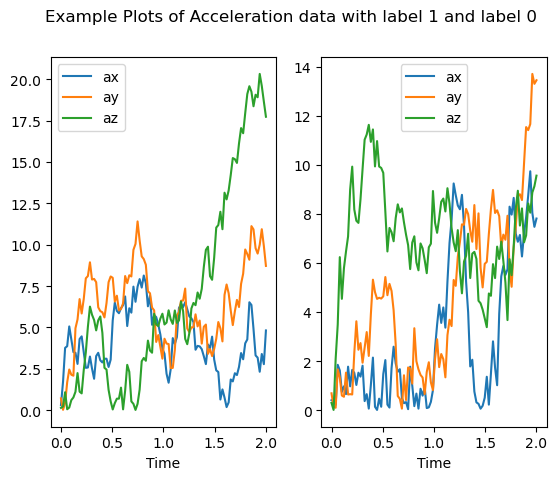

In [18]:
yNumpy = [df.loc[0,'Label'] for df in y_trainPre]
idx1, idx2 = yNumpy.index(1), yNumpy.index(0)

fig, (ax0,ax1) = plt.subplots(1,2)
fig.suptitle('Example Plots of Acceleration data with label 1 and label 0')

x_trainPre[idx1].plot(x = 'Time', y = ['ax', 'ay','az'],kind='line', ax = ax0)
x_trainPre[idx2].plot(x = 'Time', y = ['ax', 'ay','az'],kind='line', ax = ax1)
plt.show()


We start preprocessing the data by removing all nan-values. If a dataframe contains more than 5 nan-values in a single column we remove it. Otherwise we replace all the missing values by the mean of corresponding column.

Next we check that all labels are binary and remove them if necessary.

In [ ]:
# clean data
# remove all nan-values and replace by mean
for idx,df in enumerate(x_trainPre):
    count = df[['ax','ay','az']].isna().sum().to_numpy()
    if(any(i > 5 for i in count)):
        x_trainPre.remove(df)
        y_trainPre.pop(idx)
    for idx,counter in enumerate(count):
        if(counter):
            mean = df.iloc[:,idx + 1].mean()
            df.iloc[:, idx + 1] = df.iloc[:, idx + 1 ].replace(np.nan, mean)
# check if all labels are binary
for idx,df in enumerate(y_trainPre):
    if (df[['Label']].to_numpy() not in [[0],[1]]):
        y_trainPre.remove(df)
        x_trainPre.pop(idx)      

To simplify some of the following preprocessing steps, we transform the data into a multidimensional numpy array.

In [ ]:
# bring data into correct format
x_train_numpy = np.empty([10000,3,100])
y_train_numpy = np.empty([10000,1])
for idx, df in enumerate(x_trainPre):
    x_train_numpy[idx,:,:] = df[['ax','ay','az']].transpose().to_numpy()
for idx, df in enumerate(y_trainPre):
    y_train_numpy[idx,:] = df[['Label']].to_numpy()

Now we want to normalise all entries in our data matrices into the interval (0,1) by using a MinMaxScaler. This will speed up the training process.  Since Python does'nt provide a MinMaxScaler for 3-dimensional training data, we use a class that extends the provided scaler.

In [ ]:
# scale all values into (0,1)
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

    scaler = MinMaxScaler3D()
x_trainScaledNumpy = scaler.fit_transform(x_train_numpy)

In [ ]:
import pywt
for array in x_train_numpy:
    ax_data = array[0]
    ay_data = array[1]
    az_data = array[2]
    for k in range(3):
        (ax_data, coef) = pywt.dwt(ax_data, 'sym5')
        (ay_data, coef) = pywt.dwt(ay_data, 'sym5')
        (az_data, coef) = pywt.dwt(az_data, 'sym5')

time = np.linspace(0,2,100)
plt.plot(time, x_train_numpy[-1,0], color = 'red')
plt.plot(np.linspace(0,2,len(ax_data)), ax_data)

We split the data into training and test data, once for the raw data and once for the normalized data, so we can evaluate our models performance accordingly. In order to achieve comparability we fix the random state.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train_numpy, y_train_numpy, test_size = 0.1,
                                                    random_state = 42)
x_trainNormalized, x_testNormalized, y_train, y_test = train_test_split(x_trainScaledNumpy, y_train_numpy, 
                                                                        test_size = 0.1, 
                                                                        random_state = 42 )

The following code block initializes 3 different type of models used to predict the functionality of the vibration dampers. We test a fully connected model, an LSTM model and a CNN model. Obviously the network's architecture can be varied trivially.

In [ ]:
# build a simple fully-connected model

modelDense = tf.keras.models.Sequential([
    tf.keras.Input(shape = (3,100,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu', name = 'firstLayer'),
    tf.keras.layers.Dense(10, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])
modelLSTM = tf.keras.models.Sequential([
    tf.keras.Input(shape = (3,100,)),
    tf.keras.layers.LSTM(units = 128, return_sequences=True, activation = 'relu'),
    tf.keras.layers.LSTM(units = 64, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])

# save initial random weights in order to reset the model later
weightsDense, weightsLSTM = modelDense.get_weights(), modelLSTM.get_weights()

# compile model
modelDense.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])
modelLSTM.compile(optimizer = 'SGD', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                   metrics = ['accuracy'])

In [ ]:
# train model
historyRawDense = modelDense.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 0)
performanceUnnormalizedDense = modelDense.evaluate(x_test, y_test)[1]
plt.plot(historyRawDense.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized dense model')
plt.show()
plt.plot(historyRawDense.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized dense model')

In [ ]:
# reset model weights
modelDense.set_weights(weightsDense)
historyNormalizedDense = modelDense.fit(x_trainNormalized, y_train, epochs = 100, batch_size = 256, verbose = 0)
performanceNormalizedDense = modelDense.evaluate(x_testNormalized, y_test)[1]

plt.plot(historyNormalizedDense.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.title('Training Loss of unnormalized dense model')
plt.show()
plt.plot(historyNormalizedDense.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy of unnormalized dense model')


In [ ]:
fig, ax = plt.subplots()
print([performanceUnnormalizedDense, performanceNormalizedDense])
ax.bar(['unnormalized Dense', 'normalized Dense'], 
       [performanceUnnormalizedDense, performanceNormalizedDense], color = ['blue', 'red'])
ax.set_ylabel('Test accuracy')
ax.set_title('Achieved Test Accuracy of different models')
ax.set_ylim(0,1)

In [ ]:
modelLSTM.fit(x_train, y_train, epochs = 100)

In [ ]:
modelDense.evaluate(x_test, y_test)
modelLSTM.evaluate(x_test, y_test)